In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.shape

(284580, 6)

In [3]:
categ_str_features = ['country', 'source']
categ_int_features = ['new_user']
numeric_features = ['age', 'total_pages_visited']
target = 'converted'

In [110]:
X = df.iloc[:, :-1]
y = df.loc[:, 'converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [111]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']
# numeric_features = ['total_pages_visited']
# categ_features = ['new_user']

num_transf = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler())
)

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features)
)

In [112]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [61]:
284580 / 2 * np.bincount(y)

array([3.9186666e+10, 1.3062222e+09])

In [151]:
model = LogisticRegression()

In [124]:
scores_lr = cross_val_score(model, X_train, y_train, cv=5)
print(scores_lr.mean())
print(scores_lr.std())

0.986283878721137
0.00020985533466930093


In [157]:
# class_weight='balanced' ==> n_samples / (n_classes * np.bincount(y)) ==> 
params = {
    'C' : [1.025, 1.027, 1.029, 1.031, 1.032,1.034],
    'penalty' : ['l1','l2']
}

gridsearch_lr = GridSearchCV(model, param_grid = params, cv=10)
gridsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1.025, 1.027, 1.029, 1.031, 1.032, 1.034],
                         'penalty': ['l1', 'l2']})

In [158]:
print("Best hyperparameters : ", gridsearch_lr.best_params_)
print("Best R2 score : ", gridsearch_lr.best_score_)

Best hyperparameters :  {'C': 1.027, 'penalty': 'l2'}
Best R2 score :  0.9862526435130908


In [159]:
y_train_pred_lr = gridsearch_lr.predict(X_train)
y_test_pred_lr = gridsearch_lr.predict(X_test)

In [160]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.7640283915896611
f1-score sur le test set :  0.7595396729254997


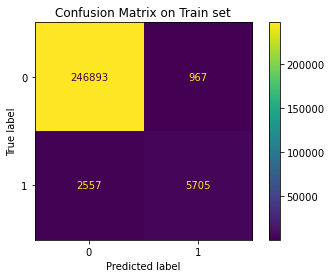

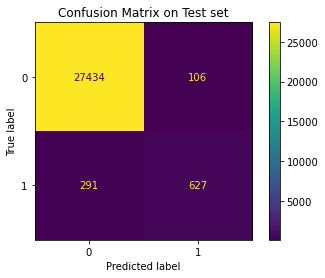

In [161]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_test, y_test, ax=ax) 
plt.show()

In [162]:
from xgboost import XGBClassifier

In [178]:
xgboost = XGBClassifier()

params = {
    'max_depth': [4,5,6,7,8], # exactly the same role as in scikit-learn
    'min_child_weight': [3.5,4.0,5.0], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [14,15,17,20] # exactly the same role as in scikit-learn
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv=10) 
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [3.5, 4.0, 5.0],
                         'n_estimators': [14, 15, 17, 20]})

In [179]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 3.5, 'n_estimators': 20}
Best R2 score :  0.9861238011656814


In [175]:
y_train_pred_xgboost = gridsearch.predict(X_train)
y_test_pred_xgboost = gridsearch.predict(X_test)

In [176]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_xgboost))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_xgboost))

f1-score sur le train set :  0.7677882697167177
f1-score sur le test set :  0.7568862275449102


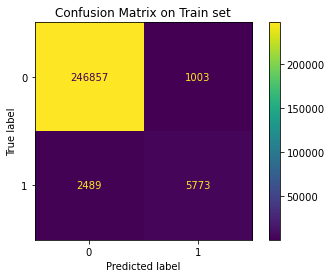

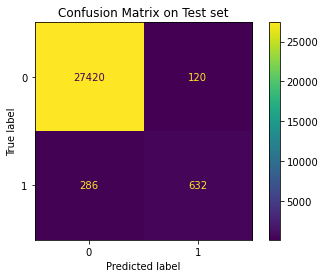

In [177]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) 
plt.show()

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [181]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [184]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'],
                    max_depth = int(space['max_depth']),
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [185]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.9853468269028042                                                                                                     
SCORE:                                                                                                                 
0.985663082437276                                                                                                      
SCORE:                                                                                                                 
0.9835547122074636                                                                                                     
SCORE:                                                                                                                 
0.9847494553376906                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.9855576639257854                                                                                                     
SCORE:                                                                                                                 
0.9847845948415208                                                                                                     
SCORE:                                                                                                                 
0.9854171059104645                                                                                                     
SCORE:                                                                                                                 
0.9854171059104645                                                                                                     
SCORE:                                  

In [186]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5932617287877644, 'gamma': 1.3650137578892094, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_alpha': 51.0, 'reg_lambda': 0.8217358660799771}


In [194]:
xgboost = XGBClassifier(
     colsample_bytree=0.5932617287877644,
     gamma=1.3650137578892094,
     max_depth=6,
     min_child_weight=3.0, 
     reg_alpha=51.0, 
     reg_lambda=0.8217358660799771
)

In [195]:
evaluation = [( X_train, y_train), ( X_test, y_test)]

xgboost.fit(X_train, y_train,
            eval_set=evaluation,
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5932617287877644, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.3650137578892094, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=51.0, reg_lambda=0.8217358660799771, ...)

In [200]:
y_train_pred_xgboost = xgboost.predict(X_train)
y_test_pred_xgboost = xgboost.predict(X_test)

In [201]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_xgboost))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_xgboost))

f1-score sur le train set :  0.7652544630961896
f1-score sur le test set :  0.7570485902819436


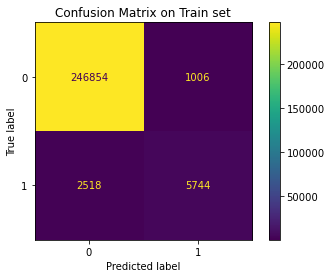

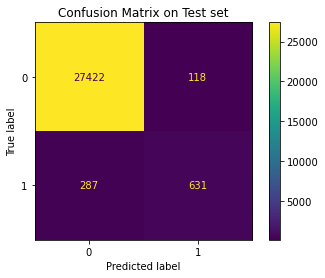

In [202]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(xgboost, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(xgboost, X_test, y_test, ax=ax) 
plt.show()

In [203]:
import pickle

with open('xgboost_model', 'wb') as f:
    pickle.dump(xgboost, f)

In [204]:
data_without_labels = pd.read_csv('conversion_data_test.csv')

In [205]:
data_without_labels.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [206]:
X = preprocessor.transform(data_without_labels)

In [208]:
data = {
    'converted': xgboost.predict(X)
}

In [209]:
y_predictions = pd.DataFrame(columns=['converted'],data=data)
y_predictions.to_csv('conversion_data_test_predictions_david.csv', index=False)

In [210]:
y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,0


In [211]:
with open('svc_proba_model', 'rb') as f:
    svc = pickle.load(f)

In [214]:
cv = KFold(n_splits=10)

models = []
models.append(('xgb', xgboost))
models.append(('svc', svc))
models.append(('random_forest', gridsearch_lr))

model = VotingClassifier(models)
score = cross_val_score(model, X_train, y_train, cv=cv)
score.mean()

0.9861745557267826

In [215]:
model.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5932617287877644,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            gamma=1.3650137578892094, gpu_id=-1,
                                            grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            le...
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0,
                                            reg_alpha=51.0,
                                            reg_lambda=0.8217358660799771, ...)),
                             ('svc', SVC(C=48, gamma=0.0005, probability=True)),
                             ('random_forest',
                              GridSearchCV(cv=10,
                                           estimator=LogisticRegression(),
                                           param_grid={'C': [1.025, 1.027,
                                                             1.029, 1.031,
                                                             1.032, 1.034],
                                                       'penalty': ['l1',
                                                                   'l2']}))])

In [217]:
voting_pred_train = model.predict(X_train)
voting_pred_test = model.predict(X_test)

In [218]:
print("f1-score sur le train set : ", f1_score(y_train, voting_pred_train))
print("f1-score sur le test set : ", f1_score(y_test, voting_pred_test))

f1-score sur le train set :  0.7624368899360484
f1-score sur le test set :  0.7577413479052825


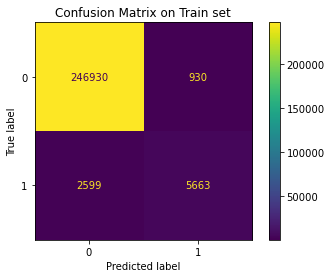

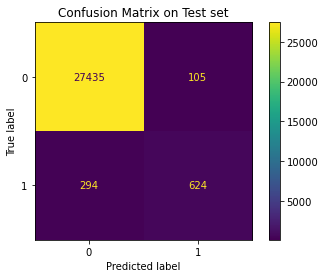

In [220]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax) 
plt.show()

In [221]:
with open('voting_model', 'wb') as f:
    pickle.dump(model, f)

In [222]:
data = {
    'converted': model.predict(X)
}

In [223]:
y_predictions = pd.DataFrame(columns=['converted'],data=data)
y_predictions.to_csv('conversion_data_test_predictions_david2.csv', index=False)